In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time 

In [0]:
cifar10 = keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [0]:
num_classes = 10

# preprocessing
train_images = train_images / 255.0
test_images = test_images / 255.0

# normalize images
train_images_norm = (train_images - np.mean(train_images, axis=(0, 1, 2, 3))) / np.std(train_images, axis=(0, 1, 2, 3))
test_images_norm = (test_images - np.mean(test_images, axis=(0, 1, 2, 3))) / np.std(test_images, axis=(0, 1, 2, 3))

# change labels to categorical
train_labels_bin = keras.utils.to_categorical(train_labels, num_classes)
test_labels_bin = keras.utils.to_categorical(test_labels, num_classes)

In [0]:
def cifar10model():
  # define the model; architecture inspired by Keras documentation
  model = keras.Sequential([
      keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=train_images.shape[1:], activation='relu'),
      keras.layers.Conv2D(32, (3, 3), activation='relu'),
      keras.layers.MaxPooling2D(pool_size=(2, 2)),
      keras.layers.Dropout(0.25),
      keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
      keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
      keras.layers.MaxPooling2D(pool_size=(2, 2)),
      keras.layers.Dropout(0.25),
      keras.layers.Flatten(),
      keras.layers.Dense(512, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(num_classes, activation='softmax')
  ])
  model.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])
  return model

### Standard Training

In [0]:
model = cifar10model()

In [57]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 15, 15, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 7, 7, 64)         

In [58]:
train_results = model.fit(train_images_norm, train_labels_bin, batch_size=32, epochs=5)

Epoch 1/5
1563/1563 [==============================] - 247s 158ms/step - loss: 1.3831 - accuracy: 0.5011
Epoch 2/5
1563/1563 [==============================] - 248s 159ms/step - loss: 0.9902 - accuracy: 0.6529
Epoch 3/5
1563/1563 [==============================] - 247s 158ms/step - loss: 0.8433 - accuracy: 0.7026
Epoch 4/5
1563/1563 [==============================] - 247s 158ms/step - loss: 0.7723 - accuracy: 0.7292
Epoch 5/5
1563/1563 [==============================] - 249s 159ms/step - loss: 0.7082 - accuracy: 0.7506


In [45]:
results = model.evaluate(test_images_norm, test_labels_bin, batch_size=128)

79/79 [==============================] - 11s 136ms/step - loss: 0.6828 - accuracy: 0.7648


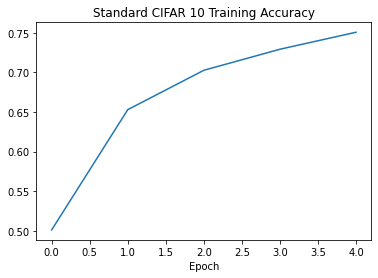

In [72]:
sns.lineplot(list(range(len(train_results.history['accuracy']))), train_results.history['accuracy'])
plt.title('Standard CIFAR 10 Training Accuracy')
plt.xlabel('Epoch')
plt.savefig('figs/standard.jpg')
plt.show()

### Setup for Federated Learning

In [0]:
class Device:
  dev_train_images = None
  dev_train_labels = None
  model = None

In [0]:
NUM_ROUNDS = 20
DEV_PER_ROUND = 5
DEV_PERC = 0.02 # percentage of data per round

### Standard Federated Learning
Using `FedAvg` under IID non-adversarial setting.

In [54]:
### STANDARD FEDERATED LEARNING
rounds = NUM_ROUNDS
devices_per_round = DEV_PER_ROUND
perc_per_device = DEV_PERC # percentage of data per round
total_data = train_images.shape[0]
data_per_device = int(perc_per_device * total_data)

server_model = cifar10model()

test_accs = []

# federated learning
for r in range(rounds):
  # create devices
  devices = [Device() for _ in range(devices_per_round)]
  allweights = []
  for i in range(len(devices)):
    print('Round #' + str(r + 1) + ' Device #' + str(i + 1))
    # create new model for device loaded from server
    devices[i].model = cifar10model()
    for layer_index in range(len(devices[i].model.weights)):
      devices[i].model.weights[layer_index].assign(server_model.weights[layer_index])

    # assign data to device to mimic local data
    dev_indices = np.random.choice(list(range(total_data)), data_per_device)
    devices[i].train_images = train_images_norm[dev_indices]
    devices[i].train_labels = train_labels_bin[dev_indices]

    # train local device
    devices[i].model.fit(devices[i].train_images, devices[i].train_labels, 
                           batch_size=32, epochs=1)
    
    # retrieve weights for FedAvg
    allweights.append(devices[i].model.weights)
  
  # update server model with weights averaging
  avgweights = np.mean(allweights, axis=0)
  for layer_index in range(len(avgweights)):
    server_model.weights[layer_index].assign(avgweights[layer_index])
  
  # test evaluation on server model
  print('Round #' + str(r + 1) + ' Testing')
  test_acc = server_model.evaluate(test_images_norm, test_labels_bin, batch_size=32)
  print('Round #' + str(r + 1) +' Test Accuracy:', test_acc[1])
  test_accs.append(test_acc)

Round #1 Device #1
32/32 [==============================] - 5s 151ms/step - loss: 2.2393 - accuracy: 0.1640
Round #1 Device #2
32/32 [==============================] - 5s 150ms/step - loss: 2.2540 - accuracy: 0.1670
Round #1 Device #3
32/32 [==============================] - 5s 149ms/step - loss: 2.2315 - accuracy: 0.1720
Round #1 Device #4
32/32 [==============================] - 5s 150ms/step - loss: 2.2537 - accuracy: 0.1640
Round #1 Device #5
32/32 [==============================] - 5s 158ms/step - loss: 2.2485 - accuracy: 0.1600
Round #1 Testing
313/313 [==============================] - 13s 41ms/step - loss: 2.1810 - accuracy: 0.2483
Round #1 Test Accuracy: 0.2483000010251999
Round #2 Device #1
32/32 [==============================] - 5s 151ms/step - loss: 2.0460 - accuracy: 0.2530
Round #2 Device #2
32/32 [==============================] - 5s 151ms/step - loss: 2.0540 - accuracy: 0.2290
Round #2 Device #3
32/32 [==============================] - 5s 150ms/step - loss: 2.0897 - ac

### Federated Learning with Adversaries

In [55]:
### STANDARD FEDERATED LEARNING
rounds = NUM_ROUNDS
devices_per_round = DEV_PER_ROUND
perc_per_device = DEV_PERC # percentage of data per round
total_data = train_images.shape[0]
data_per_device = int(perc_per_device * total_data)

server_model = cifar10model()

test_accs_adversary = []

# federated learning
for r in range(rounds):
  # create devices
  devices = [Device() for _ in range(devices_per_round)]
  allweights = []
  for i in range(len(devices)):
    print('Round #' + str(r + 1) + ' Device #' + str(i + 1))
    # create new model for device loaded from server
    devices[i].model = cifar10model()
    for layer_index in range(len(devices[i].model.weights)):
      devices[i].model.weights[layer_index].assign(server_model.weights[layer_index])

    # assign data to device to mimic local data
    dev_indices = np.random.choice(list(range(total_data)), data_per_device)
    devices[i].train_images = train_images_norm[dev_indices]
    devices[i].train_labels = train_labels_bin[dev_indices]

    # **selecting adversary**
    adversary = False
    if i == 0: # set first device to be adversary in every round
      adversary = True

    # train local device
    if not adversary:
      devices[i].model.fit(devices[i].train_images, devices[i].train_labels, 
                           batch_size=32, epochs=1)
    else:
      # **set adversary weights**
      print('Adversary with all weights set to 1')
      for layer_index in range(len(devices[i].model.weights)):
        layer_shape = devices[i].model.weights[layer_index].shape
        devices[i].model.weights[layer_index].assign(np.ones(layer_shape))
    
    # retrieve weights for FedAvg
    allweights.append(devices[i].model.weights)
  
  # update server model with weights averaging
  avgweights = np.mean(allweights, axis=0)
  for layer_index in range(len(avgweights)):
    server_model.weights[layer_index].assign(avgweights[layer_index])
  
  # test evaluation on server model
  print('Round #' + str(r + 1) + ' Testing')
  test_acc = server_model.evaluate(test_images_norm, test_labels_bin, batch_size=32)
  print('Round #' + str(r + 1) +' Test Accuracy:', test_acc[1])
  test_accs_adversary.append(test_acc)

Round #1 Device #1
Adversary with all weights set to 1
Round #1 Device #2
32/32 [==============================] - 5s 152ms/step - loss: 2.2210 - accuracy: 0.1600
Round #1 Device #3
32/32 [==============================] - 5s 149ms/step - loss: 2.2366 - accuracy: 0.1550
Round #1 Device #4
32/32 [==============================] - 5s 153ms/step - loss: 2.1939 - accuracy: 0.1800
Round #1 Device #5
32/32 [==============================] - 5s 152ms/step - loss: 2.2311 - accuracy: 0.1800
Round #1 Testing
313/313 [==============================] - 12s 38ms/step - loss: 1003325504.0000 - accuracy: 0.1000
Round #1 Test Accuracy: 0.10000000149011612
Round #2 Device #1
Adversary with all weights set to 1
Round #2 Device #2
32/32 [==============================] - 5s 150ms/step - loss: 843080768.0000 - accuracy: 0.1150
Round #2 Device #3
32/32 [==============================] - 5s 150ms/step - loss: 741070592.0000 - accuracy: 0.1130
Round #2 Device #4
32/32 [==============================] - 5s 15

### Federated Learning with FedMedian

In [0]:
def robust_agg(list_of_weights):
  # use median over all network weights
  robust_weights = []
  for layer in range(len(list_of_weights[0])):
    layer_shape = list_of_weights[0][layer].shape
    layer_list = [list_of_weights[i][layer].numpy().flatten() for i in range(len(list_of_weights))]
    robust_weights.append(np.median(layer_list, axis=0).reshape(layer_shape))
  return robust_weights

In [57]:
### FEDERATED LEARNING WITH MEDIAN
rounds = NUM_ROUNDS
devices_per_round = DEV_PER_ROUND
perc_per_device = DEV_PERC # percentage of data per round
total_data = train_images.shape[0]
data_per_device = int(perc_per_device * total_data)

server_model = cifar10model()

test_accs_median = []

# federated learning
for r in range(rounds):
  # create devices
  devices = [Device() for _ in range(devices_per_round)]
  allweights = []
  for i in range(len(devices)):
    print('Round #' + str(r + 1) + ' Device #' + str(i + 1))
    # create new model for device loaded from server
    devices[i].model = cifar10model()
    for layer_index in range(len(devices[i].model.weights)):
      devices[i].model.weights[layer_index].assign(server_model.weights[layer_index])

    # assign data to device to mimic local data
    dev_indices = np.random.choice(list(range(total_data)), data_per_device)
    devices[i].train_images = train_images_norm[dev_indices]
    devices[i].train_labels = train_labels_bin[dev_indices]

    # **selecting adversary**
    adversary = False
    if i == 0: # set first device to be adversary in every round
      adversary = True

    # train local device
    if not adversary:
      devices[i].model.fit(devices[i].train_images, devices[i].train_labels, 
                           batch_size=32, epochs=1)
    else:
      # **set adversary weights**
      print('Adversary with all weights set to 1')
      for layer_index in range(len(devices[i].model.weights)):
        layer_shape = devices[i].model.weights[layer_index].shape
        devices[i].model.weights[layer_index].assign(np.ones(layer_shape))
    
    # retrieve weights for FedAvg
    allweights.append(devices[i].model.weights)
  
  # update server model with weights averaging
  avgweights = robust_agg(allweights)
  for layer_index in range(len(avgweights)):
    server_model.weights[layer_index].assign(avgweights[layer_index])
  
  # test evaluation on server model
  print('Round #' + str(r + 1) + ' Testing')
  test_acc = server_model.evaluate(test_images_norm, test_labels_bin, batch_size=32)
  print('Round #' + str(r + 1) +' Test Accuracy:', test_acc[1])
  test_accs_median.append(test_acc)

Round #1 Device #1
Adversary with all weights set to 1
Round #1 Device #2
32/32 [==============================] - 5s 151ms/step - loss: 2.2640 - accuracy: 0.1240
Round #1 Device #3
32/32 [==============================] - 5s 150ms/step - loss: 2.2722 - accuracy: 0.1380
Round #1 Device #4
32/32 [==============================] - 5s 152ms/step - loss: 2.2335 - accuracy: 0.1590
Round #1 Device #5
32/32 [==============================] - 5s 151ms/step - loss: 2.2405 - accuracy: 0.1570
Round #1 Testing
313/313 [==============================] - 12s 39ms/step - loss: 2.0679 - accuracy: 0.2616
Round #1 Test Accuracy: 0.26159998774528503
Round #2 Device #1
Adversary with all weights set to 1
Round #2 Device #2
32/32 [==============================] - 5s 151ms/step - loss: 2.1047 - accuracy: 0.2330
Round #2 Device #3
32/32 [==============================] - 5s 150ms/step - loss: 2.0640 - accuracy: 0.2350
Round #2 Device #4
32/32 [==============================] - 5s 150ms/step - loss: 2.1120 -

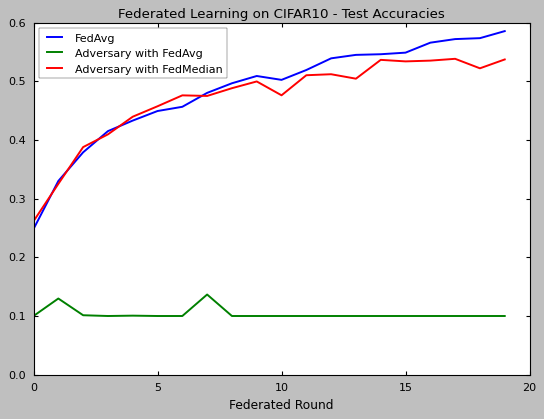

In [66]:
plt.style.use('seaborn-notebook')
sns.lineplot(list(range(len(test_accs))), [v[1] for v in test_accs])
sns.lineplot(list(range(len(test_accs_adversary))), [v[1] for v in test_accs_adversary])
sns.lineplot(list(range(len(test_accs_median))), [v[1] for v in test_accs_median])
plt.legend(['FedAvg', 'Adversary with FedAvg', 'Adversary with FedMedian'], loc=0)
plt.title('Federated Learning on CIFAR10 - Test Accuracies')
plt.xlabel('Federated Round')
plt.ylim(0, 0.6)
plt.savefig('figs/allacc.jpg')
plt.show()

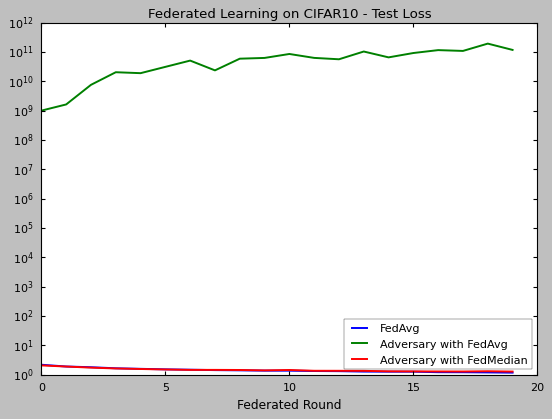

In [67]:
fig, ax = plt.subplots()
ax.set(yscale='log')
sns.lineplot(list(range(len(test_accs))), [v[0] for v in test_accs])
sns.lineplot(list(range(len(test_accs_adversary))), [v[0] for v in test_accs_adversary])
sns.lineplot(list(range(len(test_accs_median))), [v[0] for v in test_accs_median])
plt.legend(['FedAvg', 'Adversary with FedAvg', 'Adversary with FedMedian'], loc=0)
plt.title('Federated Learning on CIFAR10 - Test Loss')
plt.xlabel('Federated Round')
plt.savefig('figs/allloss.jpg')
plt.show()